# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

In [15]:
import numpy as np

from sklearn.utils import shuffle
import numpy as np
import cv2 as cv
from collections import Counter
from random import randint

#Image Normalization

XRANGE = 255.0
XMEAN = 128.0

def normalize_data(x):
    x_out = np.array(x,dtype=np.float32)

    for i in range(0,x.shape[0]):
        x_out[i,:,:,0] = (x_out[i,:,:,0])/255.0
        x_out[i,:,:,1] = (x_out[i,:,:,1])/255.0
        x_out[i,:,:,2] = (x_out[i,:,:,2])/255.0
    return x_out

X_train_norm = normalize_data(X_train)
X_valid_norm = normalize_data(X_valid)
X_test_norm = normalize_data(X_test)

## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

38


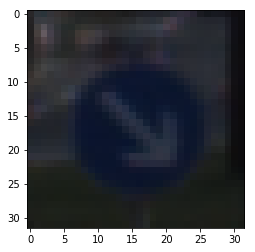

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.imshow(image)
print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [28]:
#https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification-using-6355346da2dc#.be9chacyf
def augment_brightness_camera_images(im):
    imHSV = cv.cvtColor(im,cv.COLOR_RGB2HSV)
    imHSV = np.array(imHSV, dtype = np.float32)
    random_bright = .5+np.random.uniform()
    imHSV[:,:,2] = imHSV[:,:,2]*random_bright
    imHSV[:,:,2][imHSV[:,:,2]>255]  = 255
    imHSV = np.array(imHSV, dtype = np.uint8)
    imHSV = cv.cvtColor(imHSV,cv.COLOR_HSV2RGB)
    return imHSV

def histogram_equalization_RGB(im):
    img_yuv = cv.cvtColor(im, cv.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
    return img_output

def generate_augmentation(x_t, y_t):
    
    x_t_out = np.asarray([im for im in x_t])
    
    for i in range(0,x_t.shape[0]): 
        #labels, values = zip(*y_count.items())
        #if(y_counter[y_t[i]] <= np.mean(values)):
        aug = randint(0,3)
        if(aug == 0): 
            #shift
            shift1 = randint(-3,3)
            shift2 = randint(-3,3)
            M = np.float32([[1,0,shift1],[0,1,shift2]])
            x_t_out[i] = cv.warpAffine(x_t_out[i],M,(32,32))
            #y_counter[y_t[i]] += 1
        elif(aug == 1):
            #rotate 
            rotate = 2*randint(-5,5)
            M = cv.getRotationMatrix2D((16,16),rotate,1)
            x_t_out[i] = cv.warpAffine(x_t_out[i],M,(32,32))
                #y_counter[y_t[i]] += 1
        elif(aug == 2):
                #random shear
            shear1 = 2*randint(-2,2)
            shear2 = 2*randint(-2,2)
            shear3 = 2*randint(-2,2)
            pts1 = np.float32([[8,8],[24,24],[24,8]])
            pts2 = np.float32([[8,8+shear1],[24+shear2,24],[24,8+shear3]])
            M = cv.getAffineTransform(pts1,pts2)
            x_t_out[i] = cv.warpAffine(x_t_out[i],M,(32,32))
                #y_counter[y_t[i]] += 1
        else:
            pass
                #resize
                #x_t_out[i] = cv.resize(x_t_out[i],None,fx=1.2, fy=1.2, interpolation = cv.INTER_CUBIC)[3:35,3:35,:]
                #y_counter[y_t[i]] += 1
            #x_t_out[i] = augment_brightness_camera_images(x_t_out[i])
    #plt.imshow(x_t_out[2000])
    return (x_t_out, y_t)

(69598, 32, 32, 3)


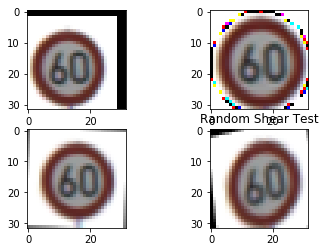

In [22]:
#Data Augmentation Tests
from scipy import ndimage
from random import randint

fig = plt.figure()

plt1 = fig.add_subplot(221)
plt2 = fig.add_subplot(222)
plt3 = fig.add_subplot(223)
plt4 = fig.add_subplot(224)

shift1 = randint(-3,3)
shift2 = randint(-3,3)
M = np.float32([[1,0,shift1],[0,1,shift2]])
X_train_translate= np.asarray([cv.warpAffine(im,M,(32,32)) for im in X_train_norm])
plt1.imshow(X_train_translate[1500])
plt.title('Random Translation Test')

X_train_resize = np.asarray([cv.resize(im,None,fx=1.2, fy=1.2, interpolation = cv.INTER_CUBIC) for im in X_train_norm])[:,3:35,3:35,:]
plt2.imshow(X_train_resize[1500])
plt.title('Resize Test')

rotate = 2*randint(-5,5)
M = cv.getRotationMatrix2D((16,16),rotate,1)
X_train_rotate = np.asarray([cv.warpAffine(im,M,(32,32)) for im in X_train_norm])
plt3.imshow(X_train_rotate[1500])
plt.title('Random Rotate Test')

shear1 = 2*randint(-2,2)
shear2 = 2*randint(-2,2)
shear3 = 2*randint(-2,2)
pts1 = np.float32([[8,8],[24,24],[24,8]])
pts2 = np.float32([[8,8+shear1],[24+shear2,24],[24,8+shear3]])
M = cv.getAffineTransform(pts1,pts2)
X_train_shear_up= np.asarray([cv.warpAffine(im,M,(32,32)) for im in X_train_norm])
plt4.imshow(X_train_shear_up[1500])
plt.title('Random Shear Test')

X_aug_test = np.concatenate((X_train_resize, X_train_translate))

print(X_aug_test.shape)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [5]:
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 512

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    dropout = 0.7
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    weights1 = tf.Variable(tf.truncated_normal([5,5,3,6],mean=mu,stddev=sigma))
    bias1 = tf.Variable(tf.truncated_normal([6],mean=mu,stddev=sigma))
    conv1 = tf.nn.conv2d(x,weights1, strides=[1,1,1,1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1,bias1)
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, dropout)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')                       
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    weights2 = tf.Variable(tf.truncated_normal([5,5,6,16],mean=mu,stddev=sigma))
    bias2 = tf.Variable(tf.truncated_normal([16],mean=mu,stddev=sigma))
    conv2 = tf.nn.conv2d(pool1, weights2, strides=[1,1,1,1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, bias2)      
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2) 
    conv2 = tf.nn.dropout(conv2, dropout)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
                           
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flat=tf.contrib.layers.flatten(pool2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    weights3 = tf.Variable(tf.truncated_normal([400,120],mean=mu,stddev=sigma))
    bias3 = tf.Variable(tf.truncated_normal([120],mean=mu,stddev=sigma))                       
    fc3 = tf.add(tf.matmul(flat, weights3),bias3)
                           
                        
    # TODO: Activation.
    fc3 = tf.nn.relu(fc3)
    
    fc3 = tf.nn.dropout(fc3)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    weights4 = tf.Variable(tf.truncated_normal([120,84],mean=mu,stddev=sigma))
    bias4 = tf.Variable(tf.truncated_normal([84],mean=mu,stddev=sigma))                       
    fc4 = tf.add(tf.matmul(fc3, weights4),bias4)
    # TODO: Activation.
    fc4 = tf.nn.relu(fc4)
    
    fc4 = tf.nn.dropout(fc4)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    weights5 = tf.Variable(tf.truncated_normal([84,43],mean=mu,stddev=sigma))
    bias5 = tf.Variable(tf.truncated_normal([43],mean=mu,stddev=sigma))                       
    logits = tf.add(tf.matmul(fc4, weights5),bias5)
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [30]:
rate = 0.005
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [31]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_norm, y_train = shuffle(X_train_norm, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = generate_augmentation(X_train_norm[offset:end], y_train[offset:end])
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        train_accuracy = evaluate(X_train_norm, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.586
Train Accuracy = 0.677

EPOCH 2 ...
Validation Accuracy = 0.745
Train Accuracy = 0.846

EPOCH 3 ...
Validation Accuracy = 0.819
Train Accuracy = 0.908

EPOCH 4 ...
Validation Accuracy = 0.837
Train Accuracy = 0.934

EPOCH 5 ...
Validation Accuracy = 0.863
Train Accuracy = 0.957

EPOCH 6 ...
Validation Accuracy = 0.881
Train Accuracy = 0.965

EPOCH 7 ...
Validation Accuracy = 0.869
Train Accuracy = 0.972

EPOCH 8 ...
Validation Accuracy = 0.895
Train Accuracy = 0.982

EPOCH 9 ...
Validation Accuracy = 0.888
Train Accuracy = 0.982

EPOCH 10 ...
Validation Accuracy = 0.905
Train Accuracy = 0.983

EPOCH 11 ...
Validation Accuracy = 0.902
Train Accuracy = 0.985

EPOCH 12 ...
Validation Accuracy = 0.898
Train Accuracy = 0.986

EPOCH 13 ...
Validation Accuracy = 0.904
Train Accuracy = 0.990

EPOCH 14 ...
Validation Accuracy = 0.909
Train Accuracy = 0.989

EPOCH 15 ...
Validation Accuracy = 0.907
Train Accuracy = 0.983

EPOCH 16 ...
Validati

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.904
